In [9]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

import sigpy.plot as pl
import os, h5py, pathlib # pathlib is a good library for reading files in a nested folders

from torch.utils.data import DataLoader, Dataset
import torch

import fastmri # We will also use fastmri library
from fastmri.data import subsample, transforms # use for generating undersampling mask, transforming tensors

In [8]:
a = '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test'
a.split('/')[-2:]
a

'/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test'

In [51]:
a = [1, 2, 3, 4]
rng = np.random.default_rng(seed = 123)
len(rng.choice(a, 1, replace = False))
list(a)

[1, 2, 3, 4]

In [53]:
# This is how you can make a custom dataset class

class MRIDataset(Dataset):
    
    def __init__(
        self, roots, scarcities, seed = 123,
        center_fractions=[0.06, 0.06, 0.06], accelerations=[4, 5, 6]
    ):
        self.rng = np.random.default_rng(seed)
        self.examples = []
        self.ratios = {}
        for idx, root in enumerate(roots):
            contrast = root.split('/')[-2]
            Files = list(pathlib.Path(root).glob('*.h5'))
            # subsample files
            Files = self.subset_sample(Files, scarcities[idx])
            self.ratios[contrast] = len(Files)
            
            # individual slices
            for fname in Files:
                h5file = h5py.File(fname, 'r')
                kspace = h5file['kspace']
                nsl = kspace.shape[0] # get number of slices
                self.examples += [(fname, sl, contrast) for sl in range(nsl)]
        
        self.mask_func = subsample.EquispacedMaskFunc(center_fractions=center_fractions, accelerations=accelerations)
        
    
    def subset_sample(self, Files, scarcity):
        '''
        decrease number of Files by 1/2^{scarcity} in a reproducible manner
        '''
        for _ in range(scarcity):
            Files = self.rng.choice(Files, int(len(Files) / 2), replace = False)
        return list(Files)
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        fname, sl, contrast = self.examples[idx]
        with h5py.File(fname, 'r') as hr:
            kspace, sens = hr['kspace'][sl], hr['sens'][sl]
        kspace = kspace / 10 # divide by 10 because the values are too large
        im_coil = sp.ifft(kspace, axes=[1, 2])
        im_true = np.sum(im_coil * np.conj(sens), axis=0) # im_true is the fully sampled reconned image
        
        mask = self.mask_func(list(im_true.shape) + [1])[...,0]                              
        mask = np.expand_dims(mask, axis=0)
        masked_kspace = kspace * mask # undersampled kspace
        mask = np.expand_dims(mask, axis=-1)
        
        # Now transform everything to tensor. The complex kspace will be changed to [real, imag] in the final axis
        masked_kspace = transforms.to_tensor(masked_kspace) 
        mask = transforms.to_tensor(mask)
        sens = transforms.to_tensor(sens)
        im_true = np.expand_dims(im_true, axis=0)
        im_true = transforms.to_tensor(im_true)
                        
        return masked_kspace, mask.byte(), sens, im_true, contrast



In [54]:
# Then you can use the dataloader like this

basefolders = [
    '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Train', 
#     '/mnt/dense/kanghyun/summer_dset/div_coronal_pd_fs/Train'
]
dset = MRIDataset(basefolders, [0])

In [55]:
# You can see what's in the dset by looking insider dset.examples

print('Total Slices:',len(dset))
# print(dset.examples) # first is path to h5file and second is the slice number
print(dset.ratios)

Total Slices: 494
{'div_coronal_pd': 13}


In [56]:
# and you can extract kspace, mask, sens, im_true by indexing
kspace, mask, sens, im_true, contrast = dset[20]
# this will take much faster if you copy the dataset to your home directory (SSD)

print(kspace.shape, mask.shape, sens.shape, im_true.shape)
# Notice that everything is in torch tensor

torch.Size([15, 577, 332, 2]) torch.Size([1, 1, 332, 1]) torch.Size([15, 577, 332, 2]) torch.Size([1, 577, 332, 2])


In [57]:
# Change the above variables to numpy again and plot them

kspace = transforms.tensor_to_complex_np(kspace)
sens = transforms.tensor_to_complex_np(sens)
im_true = transforms.tensor_to_complex_np(im_true)
print(kspace.shape, sens.shape, im_true.shape)

(15, 577, 332) (15, 577, 332) (1, 577, 332)


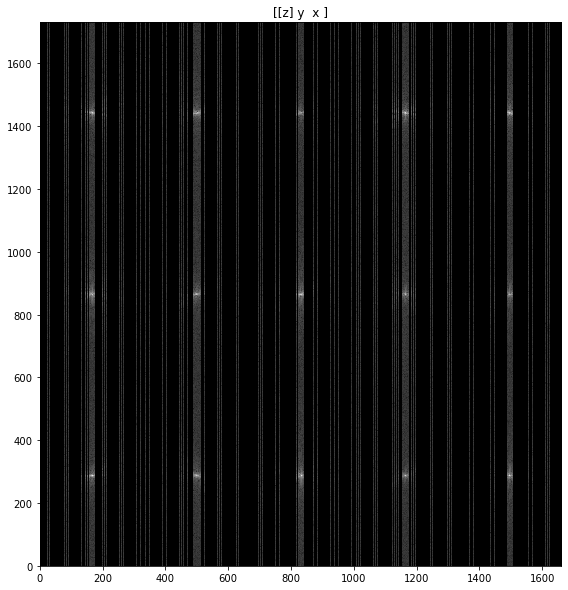

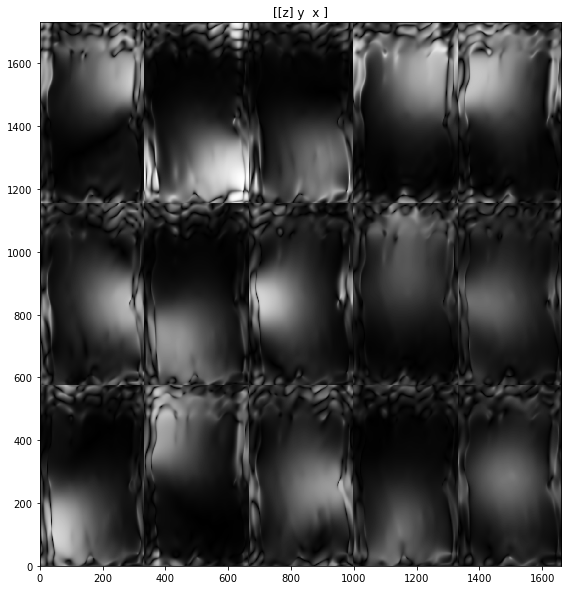

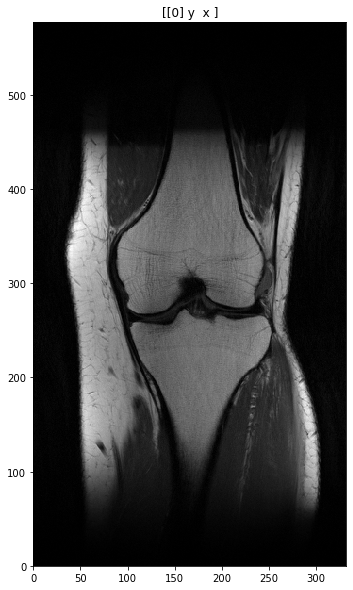

In [58]:
pl.ImagePlot(kspace**0.2,z=0) # this is undersampled kspace
pl.ImagePlot(sens,z=0) # this is sensitivity map
pl.ImagePlot(im_true) # this is true image


In [60]:
# Now let's make pytorch dataloader which can load the dataset automatically and do some useful things likes random shuffling

dloader = DataLoader(dset, batch_size=1, shuffle=True, num_workers=16)
# num_workers can stack 16 minibatch in parallel

# dloader is a generator and you can call it inside a for loop or use iterables

test_dloader = iter(dloader)
kspace, mask, sens, im_true, contrast = next(test_dloader) # notice that one more dimension is added
print(kspace.shape, mask.shape, sens.shape, im_true.shape)


torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 577, 332, 2])


(1, 15, 577, 332) (1, 15, 577, 332) (1, 1, 577, 332)


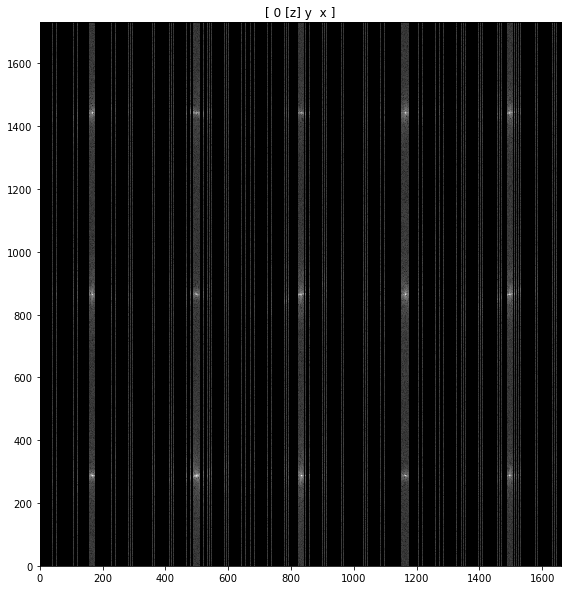

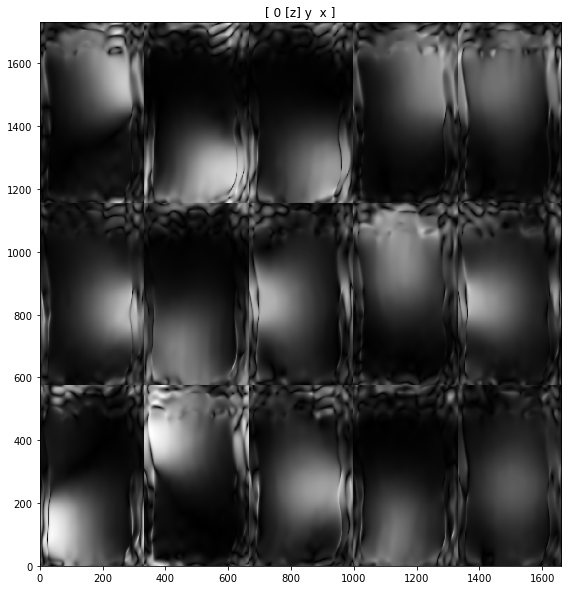

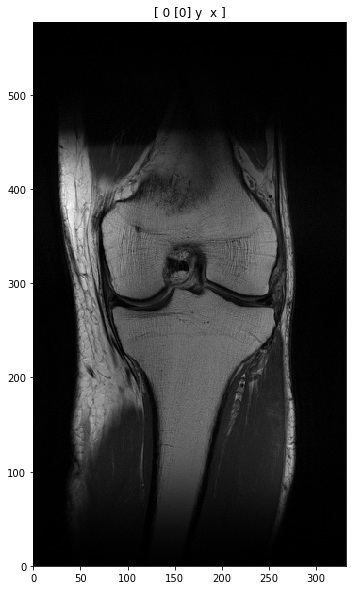

In [61]:
# Change the above variables to numpy again and plot them

kspace = transforms.tensor_to_complex_np(kspace)
sens = transforms.tensor_to_complex_np(sens)
im_true = transforms.tensor_to_complex_np(im_true)
print(kspace.shape, sens.shape, im_true.shape)

pl.ImagePlot(kspace**0.2,z=1) # this is undersampled kspace
pl.ImagePlot(sens,z=1) # this is sensitivity map
pl.ImagePlot(im_true) # this is true image


In [62]:
# now use them inside the for loop like this

for iidx, (kspace, mask, sens, im_true, contrast) in enumerate(dloader):
    print('{}th data'.format(iidx))
    print(kspace.shape, mask.shape, sens.shape, contrast)


0th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
1th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
2th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
3th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
4th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
5th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
6th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
7th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)


73th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
74th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
75th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
76th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
77th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
78th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
79th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
80th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_corona

140th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
141th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
142th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
143th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
144th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
145th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
146th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
147th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('di

205th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
206th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
207th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
208th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
209th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
210th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
211th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
212th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('di

272th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
273th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
274th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
275th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
276th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
277th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
278th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
279th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('di

347th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
348th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
349th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
350th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
351th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
352th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
353th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
354th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('di

416th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
417th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
418th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
419th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
420th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
421th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
422th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
423th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('di

491th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
492th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)
493th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) ('div_coronal_pd',)


In [ ]:
# Now we will save this code in a separate dloader.py file for further usage